In [8]:
# !pip install dalex 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import dalex as dx

# !kaggle competitions download -c playground-series-s5e10

In [2]:
data = pd.read_csv('dataset/train.csv')
df = data
target_name = 'accident_risk'
y = df[target_name]
x = df.drop([target_name,'id'], axis=1)
df['target']=y
df = df.drop(target_name,axis=1)
print(df.size)

x_train, x_val, y_train, y_val = train_test_split(x,y)
df.head()

7248556


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,target
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


### Data visualization

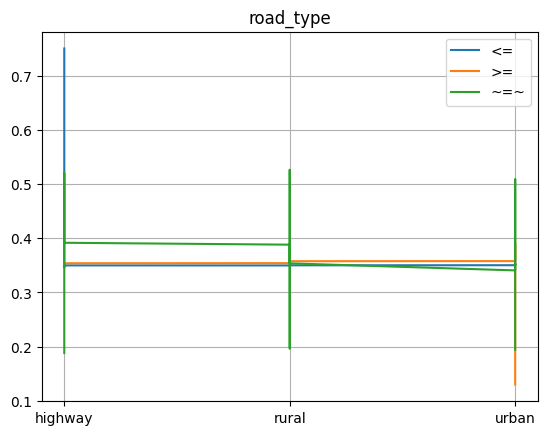

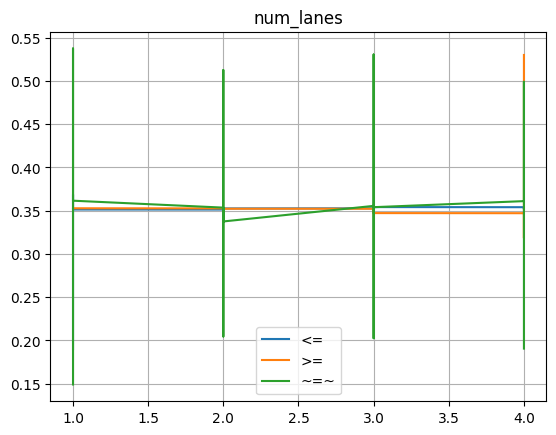

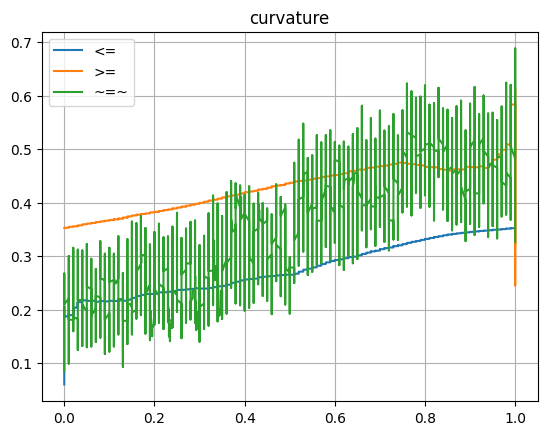

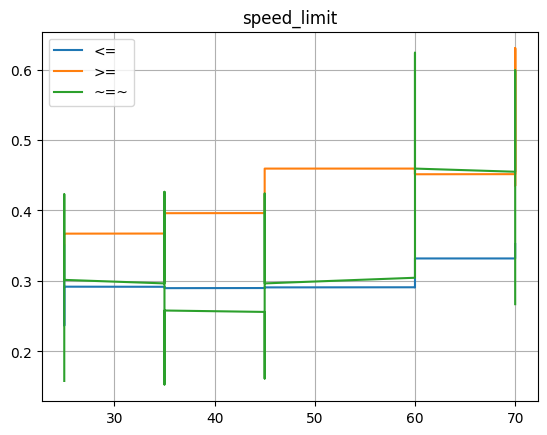

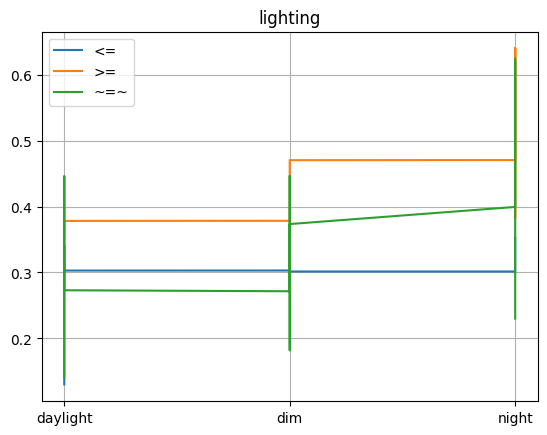

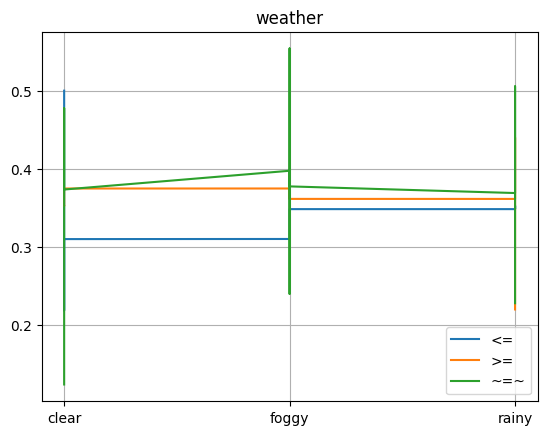

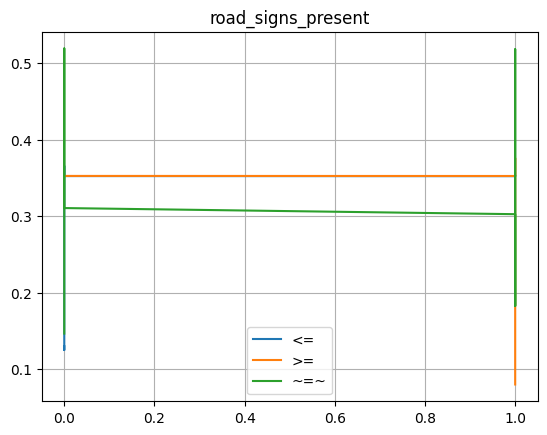

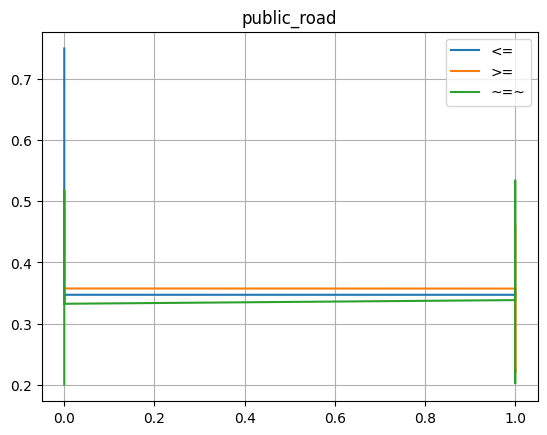

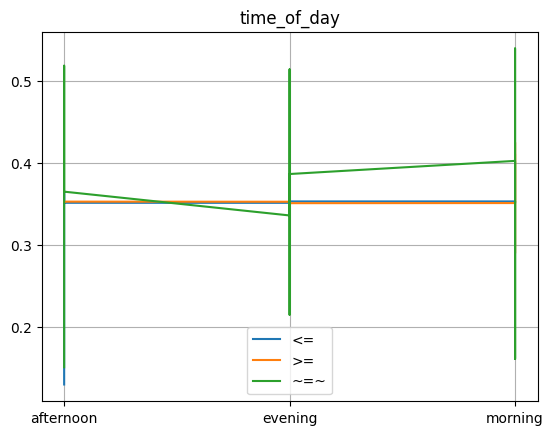

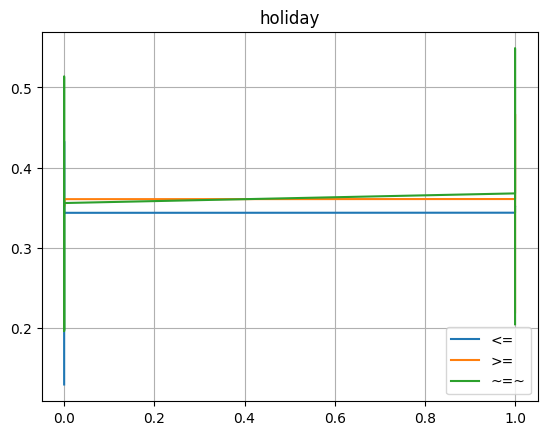

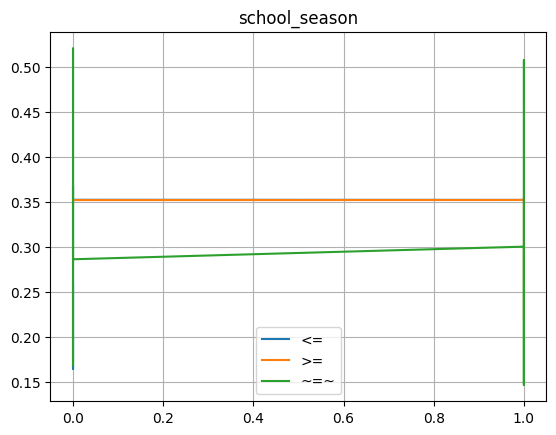

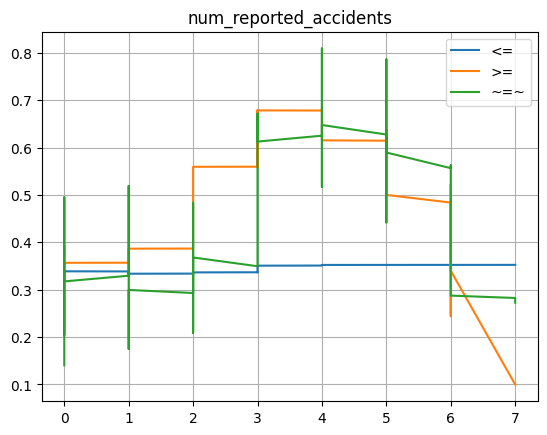

In [34]:
import numpy as np
import matplotlib.pyplot as plt

for col in df.columns.drop(['target','id']):
    tmp = df[[col, 'target']].sort_values(col).reset_index(drop=True)
    cum_le = tmp['target'].expanding().mean()
    cum_ge = tmp['target'].iloc[::-1].expanding().mean()[::-1]

    plt.title(col)
    plt.plot(tmp[col], cum_le, label="<=")
    plt.plot(tmp[col], cum_ge, label=">=")
    
    window = 20
    plt.plot(tmp[col], np.convolve(tmp['target'], np.ones(window)/window, mode='same'), label="~=~")

    plt.legend()
    plt.grid()
    plt.show()


### Creating a sklearn pipeline for data preprocessing

The dataset doesn't have any null values so Imputers aren't necessary

In [9]:
print(df.isna().sum())

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
target                    0
dtype: int64


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer

categorical_cols = [cname for cname in x.columns if
                    x[cname].nunique() < 10 and 
                    x[cname].dtype == "object"]
x[categorical_cols] = x[categorical_cols].astype(str)

numerical_cols = [cname for cname in x.columns if 
                x[cname].dtype in ['int64', 'float64']]

numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = XGBRegressor(random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
clf.fit(x,y)

preprocessor = clf.named_steps['preprocessor']

feature_names = preprocessor.get_feature_names_out()

print("Transformed feature count:", len(feature_names))

print(feature_names)

Transformed feature count: 16
['num__num_lanes' 'num__curvature' 'num__speed_limit'
 'num__num_reported_accidents' 'cat__road_type_highway'
 'cat__road_type_rural' 'cat__road_type_urban' 'cat__lighting_daylight'
 'cat__lighting_dim' 'cat__lighting_night' 'cat__weather_clear'
 'cat__weather_foggy' 'cat__weather_rainy' 'cat__time_of_day_afternoon'
 'cat__time_of_day_evening' 'cat__time_of_day_morning']
['num__num_lanes', 'num__curvature', 'num__speed_limit', 'num__num_reported_accidents', 'cat__road_type_highway', 'cat__road_type_rural', 'cat__road_type_urban', 'cat__lighting_daylight', 'cat__lighting_dim', 'cat__lighting_night', 'cat__weather_clear', 'cat__weather_foggy', 'cat__weather_rainy', 'cat__time_of_day_afternoon', 'cat__time_of_day_evening', 'cat__time_of_day_morning']


In [11]:
exp = dx.Explainer(clf, x, y,verbose=False)
fi = exp.model_parts()
fi.plot()

In [26]:
mp = exp.model_profile()
mp.plot()

Calculating ceteris paribus:   0%|          | 0/12 [00:00<?, ?it/s]c:\Users\franc\miniconda3\Lib\site-packages\dalex\predict_explanations\_ceteris_paribus\utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.   1.03 1.06 ... 3.94 3.97 4.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:  25%|██▌       | 3/12 [00:00<00:00, 19.65it/s]c:\Users\franc\miniconda3\Lib\site-packages\dalex\predict_explanations\_ceteris_paribus\utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[25.   25.45 25.9  ... 69.1  69.55 70.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

c:\Users\franc\miniconda3\Lib\site-packages\dalex\predict_explanations\_ceteris_paribus\utils.py:100: FutureWarning:

Setting an item of incompatible dtype is d

In [46]:
for i in [0,19,32]:
    print(clf.predict(x)[i])

0.13237005
0.7318035
0.41356137


In [27]:
exp.predict_parts(x.iloc[0], type='shap').plot()

In [28]:
exp.predict_parts(x.iloc[19], type='shap').plot()

In [29]:
exp.predict_parts(x.iloc[32], type='shap').plot()